In [ ]:
! pip install torchmetrics

In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.functional import f1
from string import punctuation
from nltk import TweetTokenizer
import pandas as pd
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
col_names = ['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'fav', 'stcount', 'foll', 'frien', 'listcount']

In [ ]:
positive_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NNmethods/positive.csv", header=None, sep=';', names=col_names, index_col=0)

In [ ]:
positive_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount
id,,,,,,,,,,,
408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [ ]:
negative_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NNmethods/negative.csv", header=None, sep=';', names=col_names, index_col=0)

In [ ]:
all_df = pd.concat([positive_df, negative_df], ignore_index=True)

In [ ]:
all_df["type"] = all_df["type"].replace([-1], 0)

In [ ]:
tokenized_texts = []
for i in tqdm(range(len(all_df))):
  tokenized_texts.append(word_tokenize(all_df['text'].iloc[i]))

100%|██████████| 226834/226834 [01:01<00:00, 3681.92it/s]


In [ ]:
clean_tokenized_texts = []
for text in tokenized_texts:
    text_tokens = []
    for thing in text:
        if thing not in punctuation:
            text_tokens.append(thing)
    clean_tokenized_texts.append(text_tokens)

In [ ]:
all_df.insert(3, 'text_tokenized', clean_tokenized_texts)

In [ ]:
all_df.head()

,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount,text_tokenized
0,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,"[@first_timee, хоть, я, и, школота, но, поверь..."
1,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,"[Да, все-таки, он, немного, похож, на, него, Н..."
2,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,"[RT, @KatiaCheh, Ну, ты, идиотка, я, испугалас..."
3,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,"[RT, @digger2912, Кто, то, в, углу, сидит, и, ..."
4,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,"[@irina_dyshkant, Вот, что, значит, страшилка,..."


In [ ]:
train_data, val_data = train_test_split(all_df, test_size=0.2)

In [ ]:
vocab = Counter()
for tokens in all_df['text_tokenized']:
        vocab.update(list([token.lower() for token in tokens]))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 302594


In [ ]:
filtered_vocab = set()

for token in vocab:
    if vocab[token] > 10:
        filtered_vocab.add(token)
print('уникальных токенов, встретившихся более десяти раз:', len(filtered_vocab))

уникальных токенов, встретившихся более десяти раз: 17767


In [ ]:
word2id = {'PAD':0}

for token in filtered_vocab:
    word2id[token] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
class TweetDataset(Dataset):

    def __init__(self, dataset, symbol2id, DEVICE):
        self.dataset = dataset['text_tokenized'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [ ]:
train_dataset = TweetDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
batch = next(iter(train_iterator))

In [ ]:
[id2word[int(i)] for i in batch[0][0]]

In [ ]:
val_dataset = TweetDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
test_batch = next(iter(val_iterator))

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded)
        feature_map_trigrams = self.trigrams(embedded)
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat_bigrams = self.bigrams2(concat)
        pooling = self.pooling(concat_bigrams)
        pooling = pooling.max(2)[0]

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [ ]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 9795, 11495,  6679,  ...,     0,     0,     0],
        [ 4072,  7993, 10309,  ...,     0,     0,     0],
        [15793,  7086, 13089,  ...,     0,     0,     0],
        ...,
        [16029, 13089,   795,  ...,     0,     0,     0],
        [ 4732,  8978,  7993,  ...,     0,     0,     0],
        [13089,  1214,  5430,  ...,     0,     0,     0]])


In [ ]:
loss = nn.BCELoss()

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() 
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [ ]:
model = CNN(len(word2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [ ]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
def train_eval(model, t_iterator, v_iterator, optimizer, criterion, epochs=20):
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []
    log = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for i in range(epochs):
        print(f'\nEpoch {i}')
        print('Training...')
        epoch_loss = train(model, t_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, t_iterator, criterion)
        f1s.append(f1_on_train)
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, v_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)

        log['train_loss'] = losses
        log['val_loss'] = losses_eval    
        
        if i % 10 == 0:
            fig, axs = plt.subplots(1, len(log), figsize=(15, 5))
            for i, (name, vals) in enumerate(log.items()):
                axs[i].plot(vals)
                axs[i].set_title(name)
            plt.show()
            log['val_f1'] = f1s_eval

    return losses, losses_eval, f1s, f1s_eval


Epoch 0
Training...
Train loss: 0.024997888406848207
Train loss: 0.02347231907365115
Train loss: 0.023675956046925142
Train loss: 0.023430191811254556
Train loss: 0.024068262042670416

Evaluating on train...
Val loss: 0.021141722743563792, Val f1: 1.022192120552063
Val loss: 0.02126106762907643, Val f1: 1.006906509399414
Val loss: 0.021223694712926563, Val f1: 1.0018852949142456
Val loss: 0.02121393211025128, Val f1: 0.9994325637817383
Val loss: 0.021292210262183142, Val f1: 0.9980678558349609

Evaluating on test...
Val loss: 1.7072167694568634, Val f1: 0.8910163044929504
Val loss: 1.6274725829853731, Val f1: 0.8427831530570984
Val loss: 1.6368152178250825, Val f1: 0.8258795142173767
Val loss: 1.6530042171478272, Val f1: 0.8182269334793091
Val loss: 1.6418213627555154, Val f1: 0.812772274017334


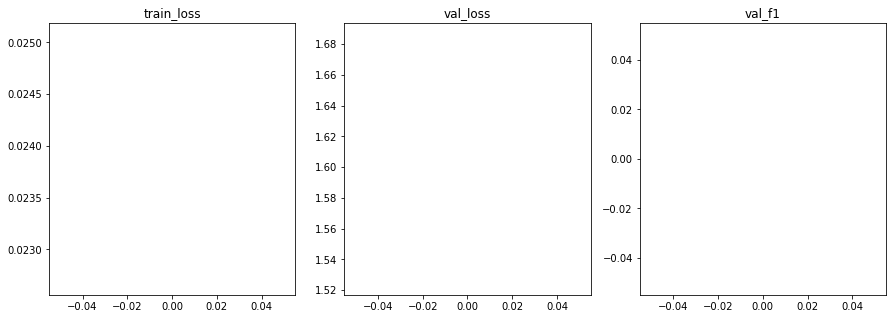


Epoch 1
Training...
Train loss: 0.021811953499255812
Train loss: 0.022227376699447632
Train loss: 0.02212040015281393
Train loss: 0.022247630144677146
Train loss: 0.022837996927100694

Evaluating on train...
Val loss: 0.024052477386944434, Val f1: 1.0181037187576294
Val loss: 0.02405943632449793, Val f1: 1.0030218362808228
Val loss: 0.024039676206974454, Val f1: 0.9978805780410767
Val loss: 0.023601065872223687, Val f1: 0.9956928491592407
Val loss: 0.02364444610095401, Val f1: 0.9941434264183044

Evaluating on test...
Val loss: 1.786432608962059, Val f1: 0.8819264769554138
Val loss: 1.7045190544689404, Val f1: 0.8346413373947144
Val loss: 1.6993836806370661, Val f1: 0.8186147212982178
Val loss: 1.7089520931243896, Val f1: 0.8115477561950684
Val loss: 1.707141174511476, Val f1: 0.8067998290061951

Epoch 2
Training...
Train loss: 0.021682037834954614
Train loss: 0.021381581661061966
Train loss: 0.021387187352117438
Train loss: 0.02221594032623785
Train loss: 0.022660311482761097

Evalua

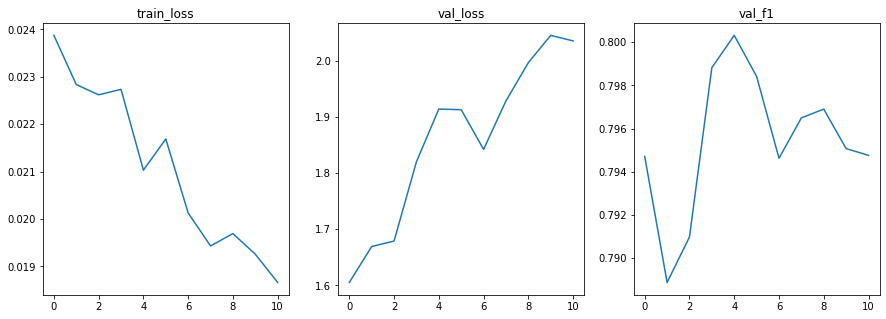


Epoch 11
Training...
Train loss: 0.017641384839354193
Train loss: 0.01789324949293033
Train loss: 0.017742219721325315
Train loss: 0.01825705856058023
Train loss: 0.01863015436128467

Evaluating on train...
Val loss: 0.017108789261649635, Val f1: 1.0192887783050537
Val loss: 0.016705218459600987, Val f1: 1.004483699798584
Val loss: 0.01718818756321875, Val f1: 0.9994422197341919
Val loss: 0.017367711873631255, Val f1: 0.9967283606529236
Val loss: 0.017274315677711677, Val f1: 0.9953222274780273

Evaluating on test...
Val loss: 2.355601504445076, Val f1: 0.8838348984718323
Val loss: 2.1952907057369457, Val f1: 0.8371341824531555
Val loss: 2.1814257548405576, Val f1: 0.821734607219696
Val loss: 2.185638734272548, Val f1: 0.8135788440704346
Val loss: 2.1593335731463, Val f1: 0.8084232211112976

Epoch 12
Training...
Train loss: 0.019219860954977134
Train loss: 0.018631492930369965
Train loss: 0.018544589679759856
Train loss: 0.018620079028145442
Train loss: 0.018615137989065427

Evaluatin

In [ ]:
losses, losses_eval, f1s, f1s_eval = train_eval(model, train_iterator, val_iterator, optimizer, criterion)